Import Libraries

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import os
import copy

# our modules
from train import *
from models import *
from datasets import *

seed = 42
torch.manual_seed(seed)
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


Training Parameters

In [40]:
class args:
    def __init__(self):
        self.dataset="mnist"
        self.batch_size=64
        self.test_batch_size=1000
        self.device='cuda'
        self.permuted=False
        self.model="digits"
        self.gamma=0.7
        self.log_name="mnist_normal"
        self.epochs=2
        self.lr=1
        self.log_interval=100
    
args = args()


Load Data

In [41]:
# first load the noraml mnist
# perm_mnist_5 = [(load_mnist(args,42))]
# perm_mnist_10 = [(load_mnist(args,42))]
perm_mnist_10 = []

# then append the 4 mnist permutations
args.permuted = True
for i in range(10):
    perm_mnist_10.append((load_mnist(args,i)))

In [42]:
# store all the results and models
all_val_losses = []
all_val_accs = []
all_val_iters = []
curr_model = None

# go over all datasets
for idx,dataset in enumerate(perm_mnist_10):
    # train the normal mnist first using model from scratch
    if idx == 0:
        print("=====================")
        print("train normal mnist")
        val_loaders = [perm_mnist_10[0][1]]
        curr_model,_,_,val_losses,val_accs,val_iters = train(args,train_loader=perm_mnist_10[0][0],val_loaders=val_loaders)
    else:
        print("=====================")
        print("train perm mnist ",idx)
        # then train on permuted mnist models
        args.log_name = "mnist_perm"+str(idx)
        # we want to see the validation over all past data
        val_loaders = [perm_mnist_10[i][1] for i in range(idx+1)]
        curr_model,train_losses,train_iters,val_losses,val_accs,val_iters = train(args,curr_model,perm_mnist_10[idx][0],val_loaders)
    all_val_losses.append(val_losses)
    all_val_accs.append(val_accs)
    all_val_iters.append(val_iters)

train normal mnist
load model from scratch
cuda
Train Epoch: 0 [0/50000 (0%)] train loss: 2.300, val loss: 2.301, val acc: 0.102 (best val acc: 0.000)
Train Epoch: 0 [6400/50000 (13%)] train loss: 0.363, val loss: 0.526, val acc: 0.834 (best val acc: 0.000)
Train Epoch: 0 [12800/50000 (26%)] train loss: 0.210, val loss: 0.291, val acc: 0.914 (best val acc: 0.000)
Train Epoch: 0 [19200/50000 (38%)] train loss: 0.364, val loss: 0.249, val acc: 0.922 (best val acc: 0.000)
Train Epoch: 0 [25600/50000 (51%)] train loss: 0.281, val loss: 0.224, val acc: 0.932 (best val acc: 0.000)
Train Epoch: 0 [32000/50000 (64%)] train loss: 0.301, val loss: 0.205, val acc: 0.941 (best val acc: 0.000)
Train Epoch: 0 [38400/50000 (77%)] train loss: 0.236, val loss: 0.217, val acc: 0.929 (best val acc: 0.000)
Train Epoch: 0 [44800/50000 (90%)] train loss: 0.114, val loss: 0.174, val acc: 0.945 (best val acc: 0.000)
In epoch 0, train loss: 0.258, val loss: 0.167, val acc: 0.948 (best val acc: 0.948))
Train Ep

3128


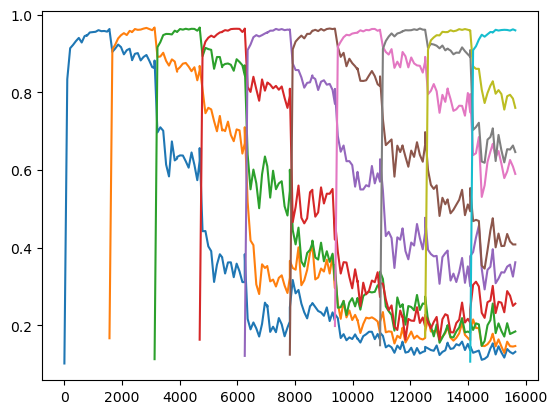

In [43]:
accs = []
iters = []
for i,exp_list in enumerate(all_val_accs):
    accs.append([])
    iters.append([])
    for j,exp in enumerate(exp_list):
        accs[j].extend(exp)
        if i == 0:
            iters[j].extend(all_val_iters[i][j])
        elif i != j:
            if i == 2 and j == 0:
                print(iters[i-1][-1])
            start = iters[i-1][-1]
            next_iter = [x+start for x in all_val_iters[i][j]]
            iters[j].extend(next_iter)
            if j == i-1:
                iters[j+1].extend(next_iter)
        else:
            pass

for idx,iter in enumerate(iters):
    plt.plot(iter,accs[idx])

In [87]:
end_model = copy.deepcopy(curr_model)

In [83]:
avg = 0
for i,vl in enumerate(perm_mnist_10):
    acc = validate(end_model,vl[1],args)[0]
    print("acc on t:",i,acc)
    avg += acc
print("avg:",avg/10)

acc on t: 0 0.1318
acc on t: 1 0.1467
acc on t: 2 0.1842
acc on t: 3 0.2559
acc on t: 4 0.3624
acc on t: 5 0.4084
acc on t: 6 0.5901
acc on t: 7 0.6464
acc on t: 8 0.7603
acc on t: 9 0.96
avg: 0.4446199999999999


In [88]:
one_batch, rem = torch.utils.data.random_split(perm_mnist_10[4][0].dataset, [64*10, 50000-64*10],torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(one_batch, batch_size=args.batch_size, shuffle=True, pin_memory=True)

In [89]:
relearn4,train_losses,train_iters,val_losses,val_accs,val_iters = train(args,end_model,train_loader,[perm_mnist_10[4][1]])

cuda
Train Epoch: 0 [0/640 (0%)] train loss: 3.303, val loss: 1.590, val acc: 0.461 (best val acc: 0.000)
In epoch 0, train loss: 0.405, val loss: 0.389, val acc: 0.878 (best val acc: 0.878))
Train Epoch: 1 [0/640 (0%)] train loss: 0.375, val loss: 0.383, val acc: 0.878 (best val acc: 0.878)
In epoch 1, train loss: 0.135, val loss: 0.327, val acc: 0.901 (best val acc: 0.901))


In [90]:
avg = 0
for i,vl in enumerate(perm_mnist_10):
    acc = validate(relearn4,vl[1],args)[0]
    print("acc on t:",i,acc)
    avg += acc
print("avg:",avg/10)

acc on t: 0 0.1476
acc on t: 1 0.1301
acc on t: 2 0.2162
acc on t: 3 0.4152
acc on t: 4 0.901
acc on t: 5 0.571
acc on t: 6 0.711
acc on t: 7 0.6715
acc on t: 8 0.6964
acc on t: 9 0.8459
avg: 0.53059


Load normal mnist

In [3]:
model = DigitClassifier()
checkpoint = torch.load("mnist_normal.pth")
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)
model.eval()

DigitClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

train on permuted after normal

In [4]:
train_simple(perm_train_loader,perm_val_loader,args,model)

cpu
Train Epoch: 0 [0/50000 (0%)] train loss: 4.032, val loss: 2.240, val acc: 0.182 (best val acc: 0.000)
Train Epoch: 0 [19200/50000 (38%)] train loss: 0.075, val loss: 0.202, val acc: 0.938 (best val acc: 0.000)
Train Epoch: 0 [38400/50000 (77%)] train loss: 0.103, val loss: 0.159, val acc: 0.950 (best val acc: 0.000)
In epoch 0, train loss: 0.198, val loss: 0.143, val acc: 0.957 (best val acc: 0.957))
Train Epoch: 1 [0/50000 (0%)] train loss: 0.108, val loss: 0.132, val acc: 0.959 (best val acc: 0.957)
Train Epoch: 1 [19200/50000 (38%)] train loss: 0.179, val loss: 0.114, val acc: 0.965 (best val acc: 0.957)
Train Epoch: 1 [38400/50000 (77%)] train loss: 0.137, val loss: 0.099, val acc: 0.970 (best val acc: 0.957)
In epoch 1, train loss: 0.112, val loss: 0.109, val acc: 0.966 (best val acc: 0.966))


check forgetting

In [6]:
model = DigitClassifier()
checkpoint = torch.load("mnist_normal_perm.pth")
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)
model.eval()
validate(model,perm_val_loader,args)

(0.9661, 0.10899652911126613)

In [ ]:
def perturb_params(model,amnt):
    with torch.no_grad():
        for idx,p in enumerate(model.parameters()):
            pert = torch.rand(p.size())
            p += (pert/torch.norm(pert)*amnt)


In [ ]:
losses = []
amnts = []
amnt = 0
for i in range(20):
    m = copy.deepcopy(model)
    perturb_params(m,amnt)

    losses.append(validate(m,val_loader,args))
    amnts.append(amnt)
    amnt += 0.025

In [ ]:
print(losses)

In [ ]:
ls = [l[1] for l in losses]
accs = [a[0] for a in losses]

ax1 = plt.subplot()
l1, = ax1.plot(amnts,ls)
ax2 = ax1.twinx()
l2, = ax2.plot(amnts,accs,color="orange")
# plt.scatter(amnts,ls)
# plt.scatter(amnts,accs)